In [ ]:
import requests
import json
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

pdir = '/local0/Kariz/expriments/runtime_prediction/tpch'
input_df = pd.read_csv('%s/%s'%(pdir,'prefetch.results.csv'))
runtime_df = pd.read_csv('%s/%s'%(pdir,'pig.results.csv'))

prefetch_path = '/local0/Kariz/expriments/runtime_prediction/tpch/%s'%('runtime.pred.pig.prefetch.csv')
stat_path = '/local0/Kariz/expriments/runtime_prediction/tpch/%s'%('runtime.pred.pig.stats.csv')

prefetch_df = pd.read_csv(prefetch_path)
stats_df = pd.read_csv(stat_path)

In [146]:
print(stats_df.columns)

print(runtime_df.columns)

result2 = pd.concat([prefetch_df, input_df])

result = pd.concat([stats_df, runtime_df])

print(result.columns)

Index(['Alias', 'AvgMapTime', 'AvgReduceTime', 'Feature', 'JobId', 'Maps',
       'MaxMapTime', 'MaxReduceTime', 'MedianMapTime', 'MedianReducetime',
       'MinMapTime', 'MinReduceTime', 'Outputs', 'Reduces', 'app_name', 'bw',
       'ds', 'framework', 'query_runtime', 'stride', 'workflow_dag', 'map_avg',
       'map_min', 'map_max', 'runtime', 'queuetime'],
      dtype='object')
Index(['Alias', 'AvgMapTime', 'AvgReduceTime', 'Feature', 'JobId', 'Maps',
       'MaxMapTime', 'MaxReduceTime', 'MedianMapTime', 'MedianReducetime',
       'MinMapTime', 'MinReduceTime', 'Outputs', 'Reduces', 'app_name', 'bw',
       'ds', 'name', 'rep', 'stride', 'map_avg', 'map_min', 'map_max',
       'runtime', 'queuetime'],
      dtype='object')
Index(['Alias', 'AvgMapTime', 'AvgReduceTime', 'Feature', 'JobId', 'Maps',
       'MaxMapTime', 'MaxReduceTime', 'MedianMapTime', 'MedianReducetime',
       'MinMapTime', 'MinReduceTime', 'Outputs', 'Reduces', 'app_name', 'bw',
       'ds', 'framework', 'map_avg'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [147]:
grp = result.groupby('Feature')
for index, g in grp:
    print(index, len(g))

COGROUP 34
DISTINCT 10
GROUP_BY 17
GROUP_BY,COMBINER 418
GROUP_BY,MULTI_QUERY 5
HASH_JOIN 847
MAP_ONLY 456
MULTI_QUERY,COMBINER 9
MULTI_QUERY,MAP_ONLY 5
ORDER_BY 382
ORDER_BY,COMBINER 22
REPLICATED_JOIN,HASH_JOIN 452
REPLICATED_JOIN,MAP_ONLY 5
SAMPLER 404


In [148]:
def process_inputs(data):
    data['prefetched_blocks'] = 4*1024*1024*get_prefetched_bytes(data['app_name'], data['JobId']);
    data['total_remote_bytes'], data['total_bytes'] = get_s3_read_size(data['JobId'])
    data['tables'] = ':'.join(get_s3_objects(data['JobId']))
    return data
    
def get_s3_objects(jobid):
    host_name='neu-3-1'
    port=19888
    url = 'http://%s:%d/ws/v1/history/mapreduce/jobs/%s/conf'%(host_name, port, jobid)
    r=requests.get(url)
    confs = r.json()['conf']['property']
    tables = [i.split('/')[-1] for i in [c['value'] for c in confs if c['name'] == 'pig.input.dirs'][0].split(',') if i.startswith('s3a')]
    return tables
    
    
def get_prefetched_bytes(app_name, jobid):
   # print(jobid) 
    host_name='neu-3-1'
    port=19888
    url = 'http://%s:%d/ws/v1/history/mapreduce/jobs/%s/conf'%(host_name, port, jobid)
    r=requests.get(url)
    confs = r.json()['conf']['property']
    inputs = [i.replace('s3a://data/', '').replace('hdfs://neu-3-1:9000/', '') for i in [c['value'] for c in confs if c['name'] == 'pig.input.dirs'][0].split(',')]
    return result2[(result2['app_name'] == app_name) & (result2['path'].isin(inputs))]['prefetched'].astype(int).sum()
    

def get_s3_read_size(job_id):
    host_name='neu-3-1'
    port=19888
    url = 'http://%s:%d/ws/v1/history/mapreduce/jobs/%s/counters'%(host_name, port, job_id)
    r=requests.get(url)
    counter_group = r.json()['jobCounters']['counterGroup']
    
    counters =  [cg['counter'] for cg in counter_group if cg['counterGroupName'] == 'org.apache.hadoop.mapreduce.FileSystemCounter'][0]
    s3a_bytes_read = [c['totalCounterValue'] for c in counters if c['name'] == 'S3A_BYTES_READ'] 
    hdfs_bytes_read = [c['totalCounterValue'] for c in counters if c['name'] == 'HDFS_BYTES_READ'] 
    return int(s3a_bytes_read[0]) if len(s3a_bytes_read) > 0 else 0, int(hdfs_bytes_read[0]) if len(hdfs_bytes_read) > 0 else 0 
    
    
    
    
dt = result.apply(process_inputs, axis=1)

dt

,Alias,AvgMapTime,AvgReduceTime,Feature,JobId,Maps,MaxMapTime,MaxReduceTime,MedianMapTime,MedianReducetime,...,query_runtime,queuetime,rep,runtime,stride,workflow_dag,prefetched_blocks,total_remote_bytes,total_bytes,tables
0,"flineitem,glineitem,lineitem,revenue,sumlineitem",16,64,"GROUP_BY,COMBINER",job_1598736990125_2567,128,22,64,15,64,...,191.0,4.703,NaN,86.110,0,['job_1598736990125_2567\t->\tjob_159873699012...,0,50361940251,48020,lineitem
1,"grevenue,max_revenue",5,2,"GROUP_BY,COMBINER",job_1598736990125_2568,1,5,2,5,2,...,191.0,4.312,NaN,12.699,0,['job_1598736990125_2567\t->\tjob_159873699012...,0,0,11454730,
2,"j1,sel,supplier,top_revenue",5,5,HASH_JOIN,job_1598736990125_2569,4,6,5,6,5,...,191.0,4.477,NaN,14.736,0,['job_1598736990125_2567\t->\tjob_159873699012...,0,90756062,11464513,supplier
3,ord,2,2,SAMPLER,job_1598736990125_2570,1,2,2,2,2,...,191.0,4.775,NaN,9.997,0,['job_1598736990125_2567\t->\tjob_159873699012...,0,0,478,
4,ord,3,2,ORDER_BY,job_1598736990125_2571,1,3,2,3,2,...,191.0,4.673,NaN,10.859,0,['job_1598736990125_2567\t->\tjob_159873699012...,0,0,478,
5,"COG,lineitem,lineitem_orders,orders",14,432,COGROUP,job_1598736990125_2572,128,25,432,14,432,...,581.0,4.205,NaN,456.244,80,['job_1598736990125_2572\t->\tjob_159873699012...,24503123968,30635729396,47726,lineitem:orders
6,"customer,lineitem_orders_customer",6,25,HASH_JOIN,job_1598736990125_2573,33,7,25,5,25,...,581.0,4.131,NaN,35.876,80,['job_1598736990125_2572\t->\tjob_159873699012...,536870912,781210282,106450,customer
7,"lineitem_orders_customer_group,result",2,3,"GROUP_BY,COMBINER",job_1598736990125_2574,1,2,3,2,3,...,581.0,4.288,NaN,11.267,80,['job_1598736990125_2572\t->\tjob_159873699012...,0,0,442192,
8,out,2,3,SAMPLER,job_1598736990125_2575,1,2,3,2,3,...,581.0,4.303,NaN,10.186,80,['job_1598736990125_2572\t->\tjob_159873699012...,0,0,135134,
9,out,2,3,ORDER_BY,job_1598736990125_2576,1,2,3,2,3,...,581.0,4.424,NaN,10.733,80,['job_1598736990125_2572\t->\tjob_159873699012...,0,0,135134,


In [214]:
dt.to_csv('pig.runtime.pred.data.csv', header=True, index=False)

In [200]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

print(dt.columns)

#dt['bw_i'] =  dt['bw'].str.replace(r'Gbps', '').astype(int)
def bandwidth_regularization(row):
    if 'Gbps' in row['bw']:
        row ['bw_i'] = float(row['bw'].replace(r'Gbps', ''))
    elif 'Mbps' in row['bw']:
        row['bw_i'] = int(row['bw'].replace(r'Mbps', ''))/1000
    else:
        raise NameError('The bandwidth string is not parsable')
    return row


dt =  dt.apply(bandwidth_regularization, axis=1)


cache_block_sz = 4*1024*1024
bw_cache = 5*(10**9)


print(dt['Reduces'].dtype)

df2 = pd.DataFrame()
df2['feature'] = dt['Feature']
df2['input_sz'] = dt['total_bytes']
df2['cache_read'] =  dt['prefetched_blocks']/bw_cache
df2['remote_read'] = np.abs((dt['total_remote_bytes'] - dt['prefetched_blocks'])/(dt['bw_i']*8*(10**9)))
#df2['remote_read'] = df2['remote_read'].apply(lambda rread: 0 if rread < 0 else rread)
df2['sequential'] = dt['total_bytes'] + dt['total_remote_bytes']
df2['aggregate'] = np.log(dt['Maps'] + dt['Reduces'])
df2['shuffle'] = (dt['Maps'] + dt['Reduces'])#*dt['total_bytes']
df2['runtime'] = dt['runtime']


df2

Index(['Alias', 'AvgMapTime', 'AvgReduceTime', 'Feature', 'JobId', 'Maps',
       'MaxMapTime', 'MaxReduceTime', 'MedianMapTime', 'MedianReducetime',
       'MinMapTime', 'MinReduceTime', 'Outputs', 'Reduces', 'app_name', 'bw',
       'ds', 'framework', 'map_avg', 'map_max', 'map_min', 'name',
       'query_runtime', 'queuetime', 'rep', 'runtime', 'stride',
       'workflow_dag', 'prefetched_blocks', 'total_remote_bytes',
       'total_bytes', 'tables', 'bw_i'],
      dtype='object')
int64


,feature,input_sz,cache_read,remote_read,sequential,aggregate,shuffle,runtime
0,"GROUP_BY,COMBINER",48020,0.000000,1.573811e-01,50361988271,4.859812,129,86.110
1,"GROUP_BY,COMBINER",11454730,0.000000,0.000000e+00,11454730,0.693147,2,12.699
2,HASH_JOIN,11464513,0.000000,2.836127e-04,102220575,1.609438,5,14.736
3,SAMPLER,478,0.000000,0.000000e+00,478,0.693147,2,9.997
4,ORDER_BY,478,0.000000,0.000000e+00,478,0.693147,2,10.859
5,COGROUP,47726,4.900625,1.916439e-02,30635777122,4.859812,129,456.244
6,HASH_JOIN,106450,0.107374,7.635605e-04,781316732,3.526361,34,35.876
7,"GROUP_BY,COMBINER",442192,0.000000,0.000000e+00,442192,0.693147,2,11.267
8,SAMPLER,135134,0.000000,0.000000e+00,135134,0.693147,2,10.186
9,ORDER_BY,135134,0.000000,0.000000e+00,135134,0.693147,2,10.733


COGROUP 
               Coefficient
remote_read  7.985206e+01
cache_read   1.100571e+01
sequential   7.838086e-09
shuffle      0.000000e+00
aggregate    0.000000e+00


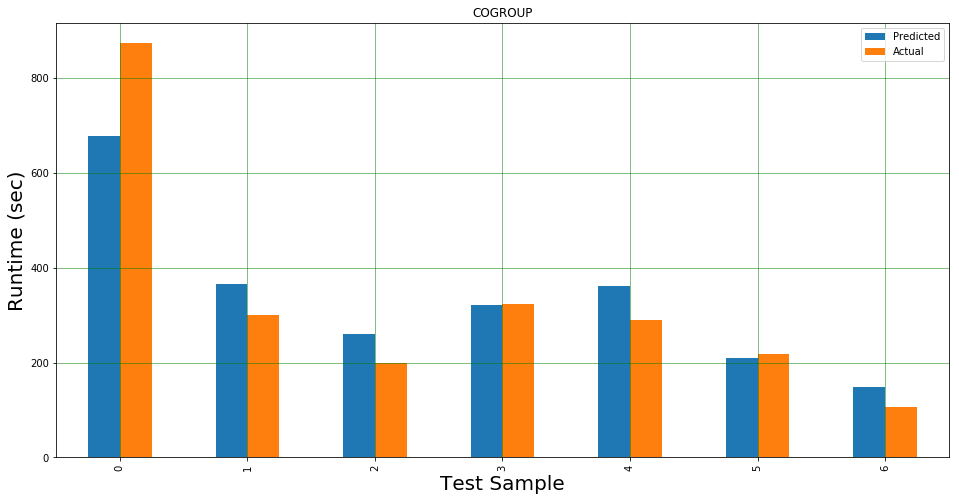

Mean Absolute Error: 63.26887389822131
Mean Squared Error: 7563.346950444827
Root Mean Squared Error: 86.96750514097106
Mean stage runtime: 380.4756470588235
******************************************************* 



DISTINCT 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   3.824482e-10
shuffle      2.700669e-01
aggregate    0.000000e+00


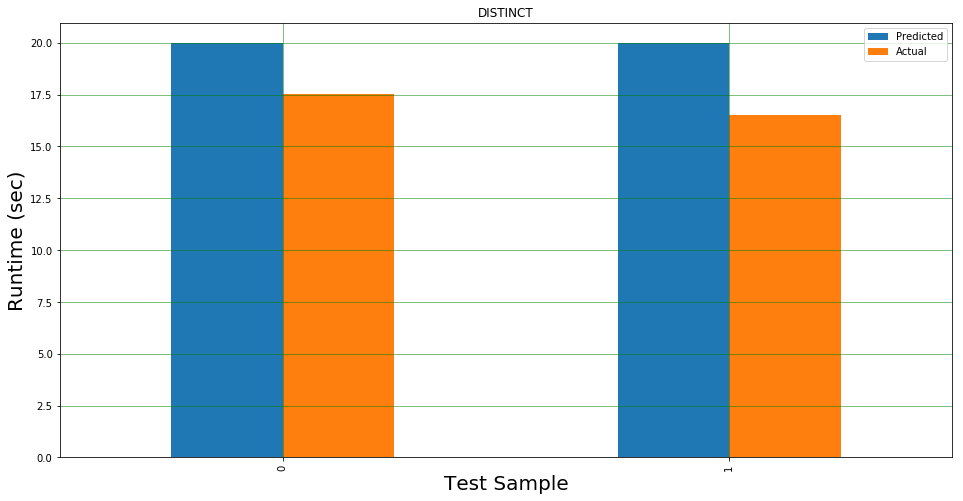

Mean Absolute Error: 2.95407115426649
Mean Squared Error: 9.006377384469353
Root Mean Squared Error: 3.001062709186423
Mean stage runtime: 15.2726
******************************************************* 



GROUP_BY 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   2.280487e-07
shuffle      0.000000e+00
aggregate    0.000000e+00


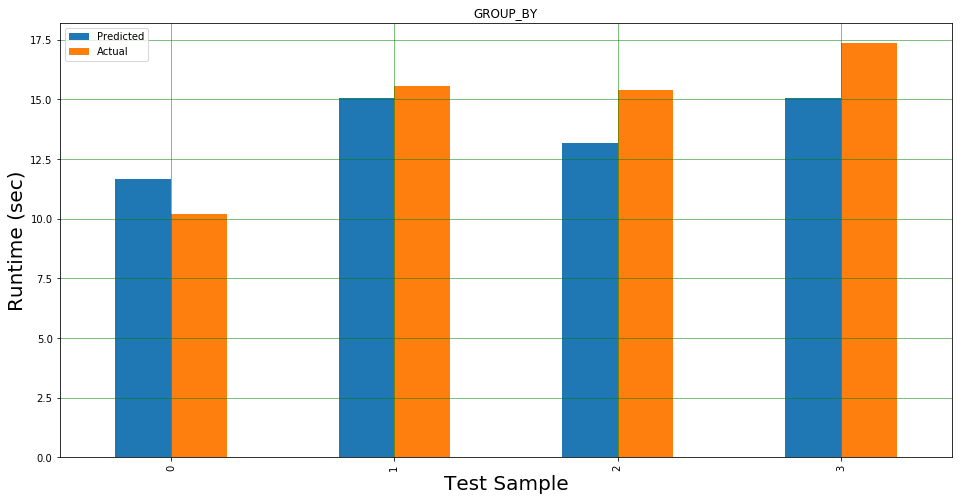

Mean Absolute Error: 1.6244836952399915
Mean Squared Error: 3.1745268207989223
Root Mean Squared Error: 1.7817201858874816
Mean stage runtime: 14.880764705882354
******************************************************* 



GROUP_BY,COMBINER 
              Coefficient
remote_read    49.110909
cache_read      4.886656
sequential      0.000000
shuffle         0.000000
aggregate      15.041029


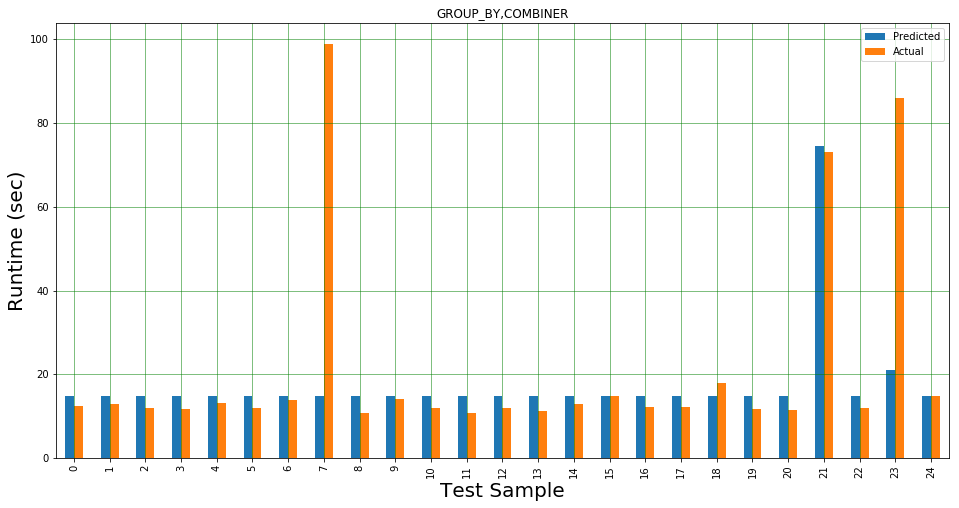

Mean Absolute Error: 8.303108960349824
Mean Squared Error: 759.1765939036108
Root Mean Squared Error: 27.553159417816513
Mean stage runtime: 20.182595693779906
******************************************************* 



GROUP_BY,MULTI_QUERY 
               Coefficient
remote_read  4.760033e+01
cache_read   0.000000e+00
sequential   8.569177e-10
shuffle      1.689680e-02
aggregate    6.567028e+02


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450.8281266837874, tolerance: 8.204656846274997
  tol, rng, random, positive)


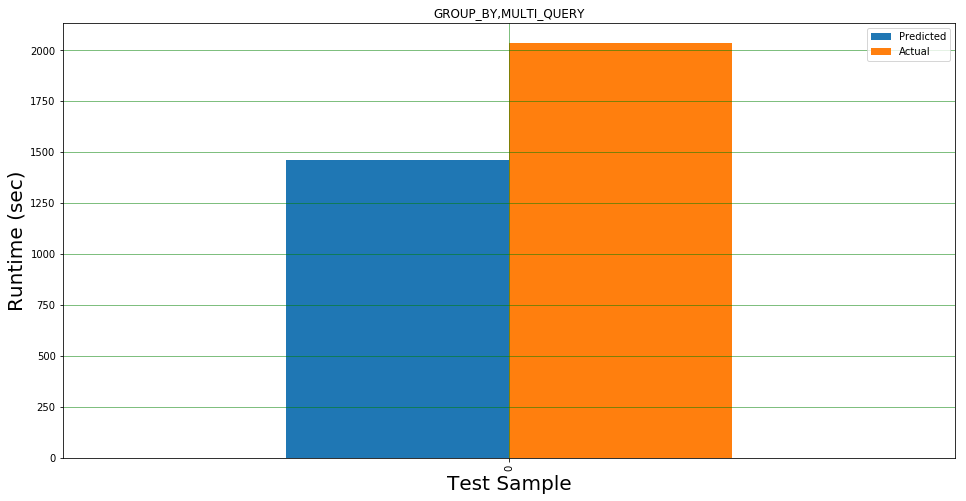

Mean Absolute Error: 574.7036327471033
Mean Squared Error: 330284.2654927173
Root Mean Squared Error: 574.7036327471033
Mean stage runtime: 1088.1136
******************************************************* 



HASH_JOIN 
               Coefficient
remote_read  5.166297e+00
cache_read   6.638363e+00
sequential   8.844512e-09
shuffle      0.000000e+00
aggregate    1.976915e+01


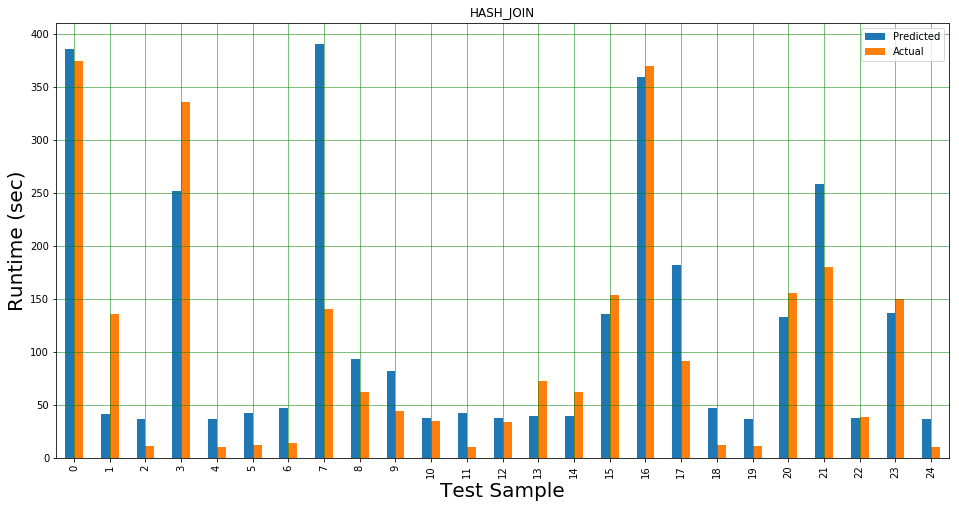

Mean Absolute Error: 37.936889144469774
Mean Squared Error: 3832.0823797552625
Root Mean Squared Error: 61.90381555086296
Mean stage runtime: 124.75444746162927
******************************************************* 



MAP_ONLY 
              Coefficient
remote_read     0.000000
cache_read      0.000000
sequential      0.000196
shuffle         0.000000
aggregate       0.000000


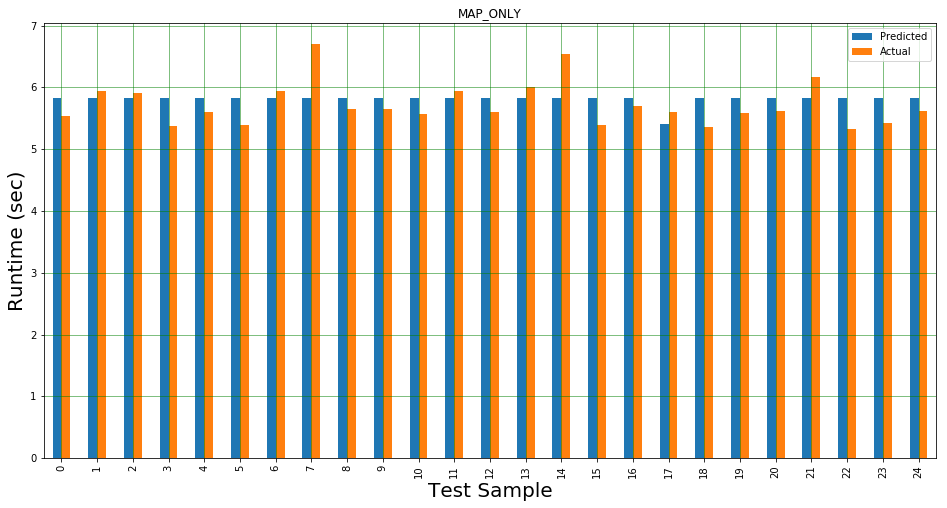

Mean Absolute Error: 0.33361228237058066
Mean Squared Error: 0.15929635964704209
Root Mean Squared Error: 0.399119480415379
Mean stage runtime: 5.8208881578947365
******************************************************* 



MULTI_QUERY,COMBINER 
              Coefficient
remote_read          0.0
cache_read           0.0
sequential           0.0
shuffle              0.0
aggregate            0.0


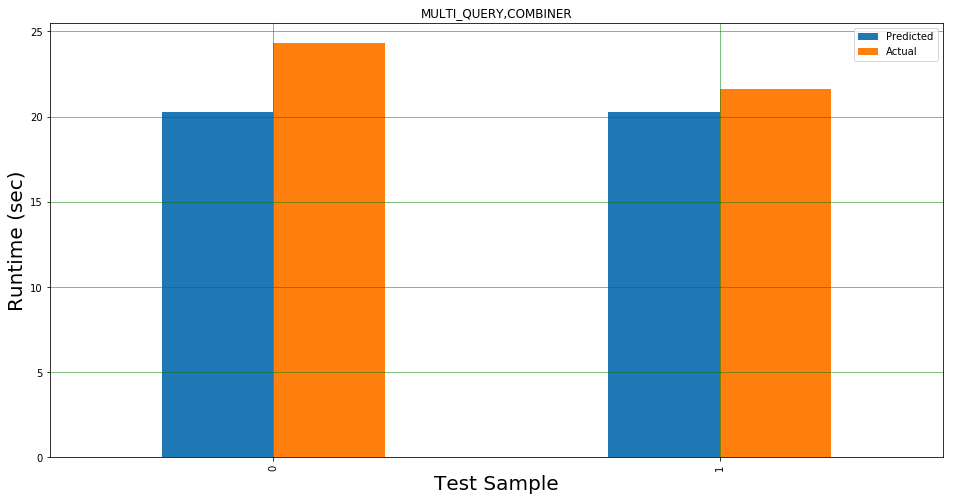

Mean Absolute Error: 2.6680714285714267
Mean Squared Error: 8.958697397959176
Root Mean Squared Error: 2.993108317111022
Mean stage runtime: 20.871333333333336
******************************************************* 



MULTI_QUERY,MAP_ONLY 
              Coefficient
remote_read          0.0
cache_read           0.0
sequential           0.0
shuffle              0.0
aggregate            0.0


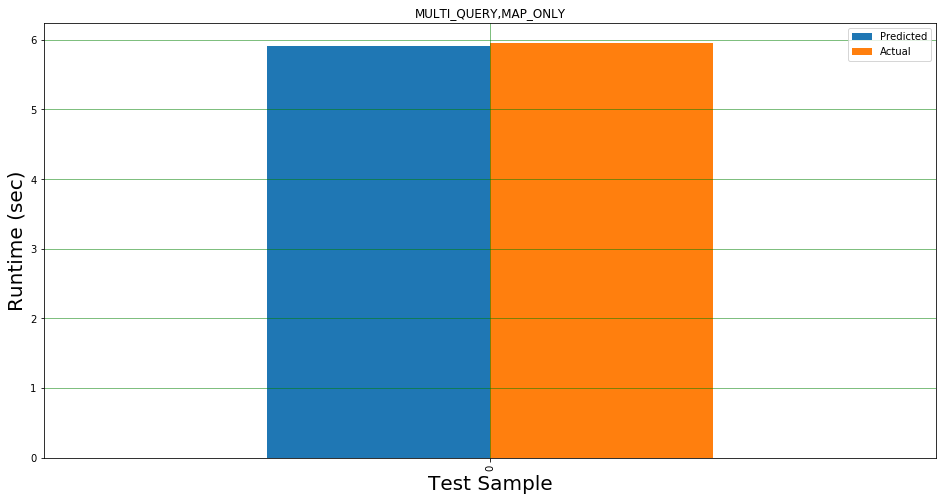

Mean Absolute Error: 0.03699999999999992
Mean Squared Error: 0.0013689999999999941
Root Mean Squared Error: 0.03699999999999992
Mean stage runtime: 5.917400000000001
******************************************************* 



ORDER_BY 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   6.076539e-07
shuffle      0.000000e+00
aggregate    0.000000e+00


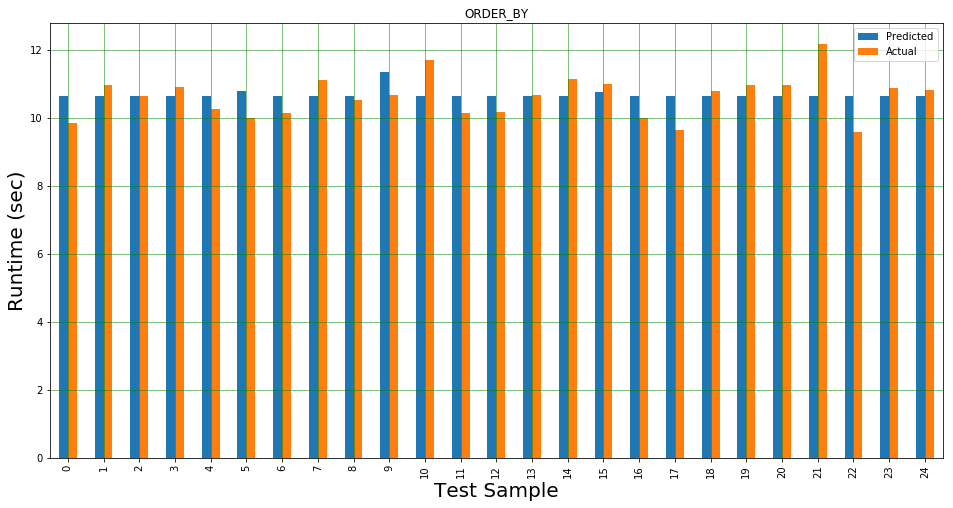

Mean Absolute Error: 0.5561283866208987
Mean Squared Error: 0.39459132459437346
Root Mean Squared Error: 0.6281650456642534
Mean stage runtime: 10.640298429319374
******************************************************* 



ORDER_BY,COMBINER 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   3.895514e-08
shuffle      0.000000e+00
aggregate    0.000000e+00


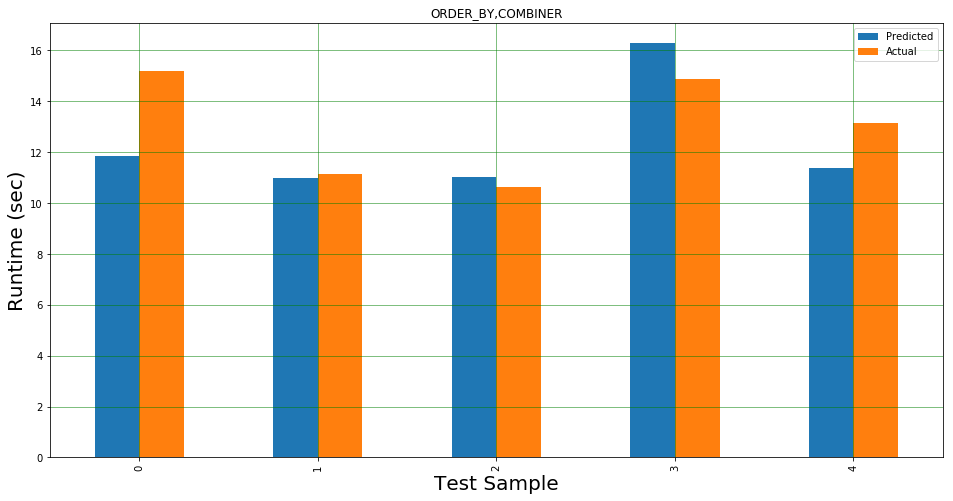

Mean Absolute Error: 1.4035165494600317
Mean Squared Error: 3.252315072447191
Root Mean Squared Error: 1.8034176089988672
Mean stage runtime: 14.462954545454545
******************************************************* 



REPLICATED_JOIN,HASH_JOIN 
               Coefficient
remote_read  9.322745e+01
cache_read   0.000000e+00
sequential   9.583773e-10
shuffle      9.494200e-01
aggregate    0.000000e+00


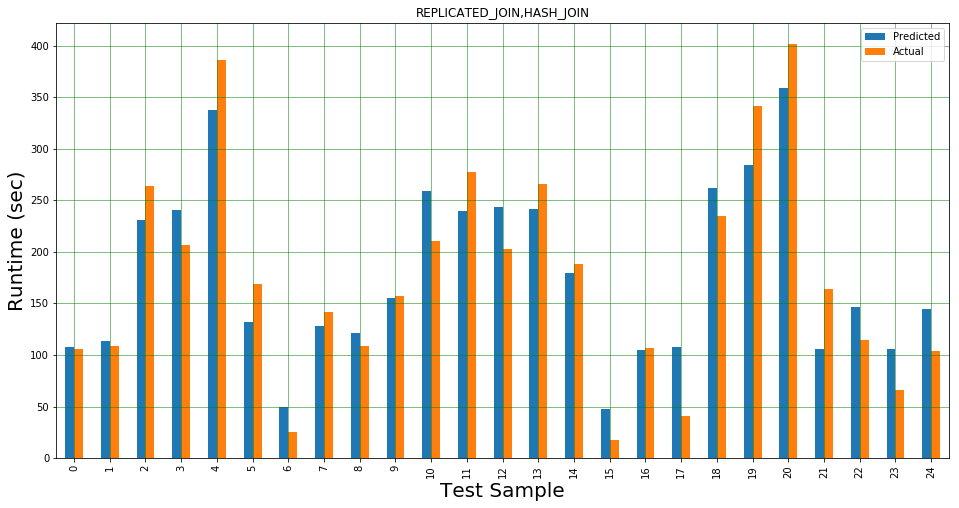

Mean Absolute Error: 55.12199676496545
Mean Squared Error: 9224.356999164014
Root Mean Squared Error: 96.04351617451339
Mean stage runtime: 227.83905088495572
******************************************************* 



REPLICATED_JOIN,MAP_ONLY 
              Coefficient
remote_read          0.0
cache_read           0.0
sequential           0.0
shuffle              0.0
aggregate            0.0


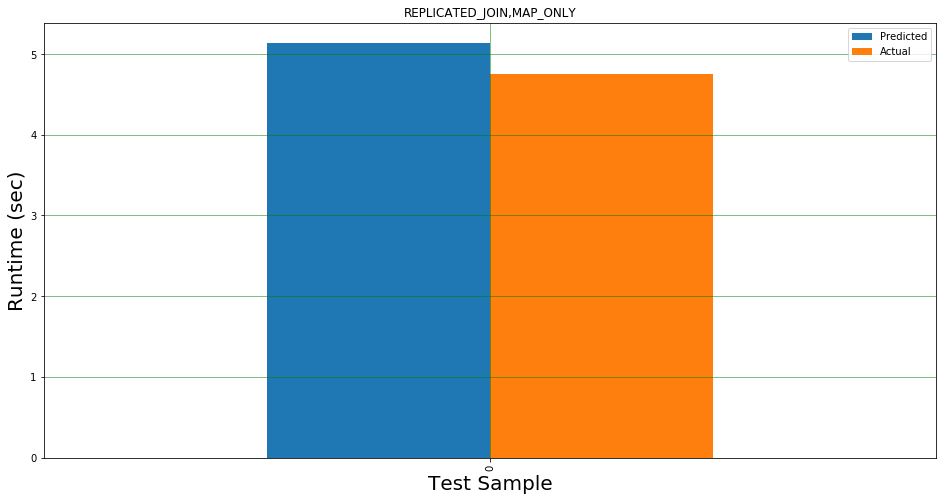

Mean Absolute Error: 0.38424999999999976
Mean Squared Error: 0.14764806249999982
Root Mean Squared Error: 0.38424999999999976
Mean stage runtime: 5.054399999999999
******************************************************* 



SAMPLER 
               Coefficient
remote_read  0.000000e+00
cache_read   0.000000e+00
sequential   8.719831e-09
shuffle      0.000000e+00
aggregate    0.000000e+00


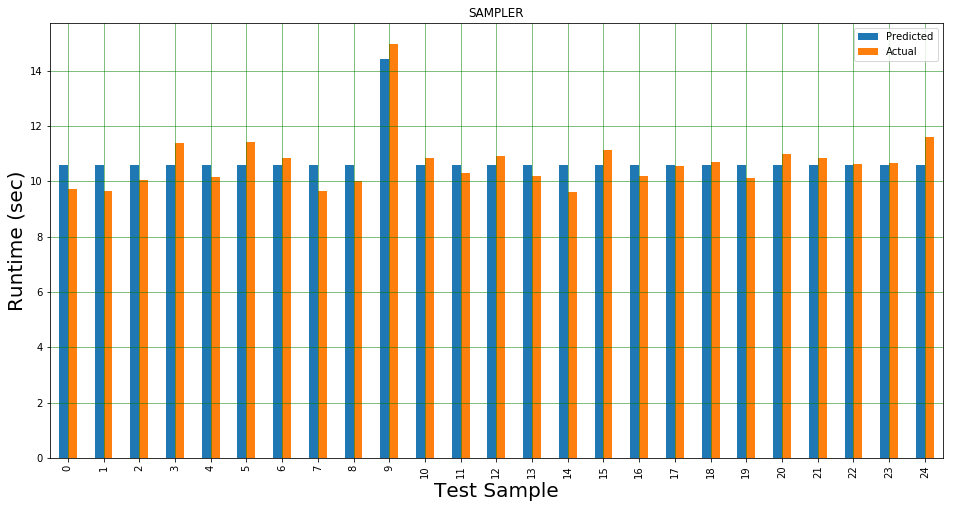

Mean Absolute Error: 0.5229636077050199
Mean Squared Error: 0.3480736543393697
Root Mean Squared Error: 0.5899776727464945
Mean stage runtime: 10.6014801980198
******************************************************* 





In [201]:
from sklearn.linear_model import Lasso

gdf2 = df2.groupby('feature')

regressors = {}

for index, df3 in gdf2:
    X = df3[['remote_read', 'cache_read', 'sequential', 'shuffle', 'aggregate']].values

    Y= df3['runtime'].values

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    regressor = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
                positive=True, random_state=9999, selection='random')
    regressor.fit(X_train,y_train)
    
    #print(X_test)
    #regressor = LinearRegression()  
    #regressor.fit(X_train, y_train)

    coeff_df = pd.DataFrame(regressor.coef_, 
                           df3[['remote_read', 'cache_read', 'sequential', 'shuffle', 'aggregate']].columns, 
                            columns=['Coefficient'])  
    print(index, '\n', coeff_df)

    y_pred = regressor.predict(X_test)

    df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df['Accuracy'] = 100*(1 - df['Predicted']/df['Actual'])

    df1 = df.head(25)

    fig, ax = plt.subplots(figsize=(16, 8))
    df1[['Predicted', 'Actual']].plot(kind='bar',ax=ax)
    ax.set_title(index)
    ax.set_xlabel('Test Sample', fontsize=20)
    ax.set_ylabel('Runtime (sec)', fontsize=20)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    
    if index not in regressors: 
        regressors[index] = regressor; 
    
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean stage runtime:', df3['runtime'].mean())
    
    print('*******************************************************', '\n\n\n')
    


In [157]:
gdf2 = df2.groupby('feature')


print(regressors)

{'COGROUP': Lasso(alpha=0.0001, positive=True, precompute=True, random_state=9999,
      selection='random'), 'DISTINCT': Lasso(alpha=0.0001, positive=True, precompute=True, random_state=9999,
      selection='random'), 'GROUP_BY': Lasso(alpha=0.0001, positive=True, precompute=True, random_state=9999,
      selection='random'), 'GROUP_BY,COMBINER': Lasso(alpha=0.0001, positive=True, precompute=True, random_state=9999,
      selection='random'), 'GROUP_BY,MULTI_QUERY': Lasso(alpha=0.0001, positive=True, precompute=True, random_state=9999,
      selection='random'), 'HASH_JOIN': Lasso(alpha=0.0001, positive=True, precompute=True, random_state=9999,
      selection='random'), 'MAP_ONLY': Lasso(alpha=0.0001, positive=True, precompute=True, random_state=9999,
      selection='random'), 'MULTI_QUERY,COMBINER': Lasso(alpha=0.0001, positive=True, precompute=True, random_state=9999,
      selection='random'), 'MULTI_QUERY,MAP_ONLY': Lasso(alpha=0.0001, positive=True, precompute=True, random_sta

TPCH_Q12


/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:637: UserWarning: Unknown parameter: size
  warnings.warn("Unknown parameter: " + k, UserWarning)


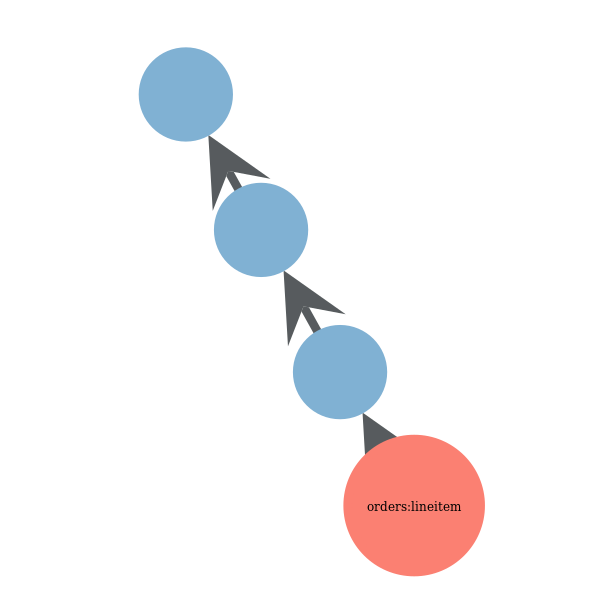

TPCH_Q17


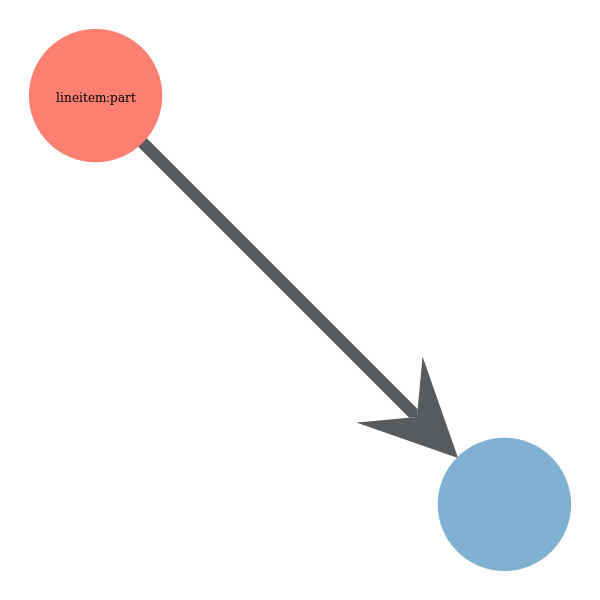

TPCH_Q9


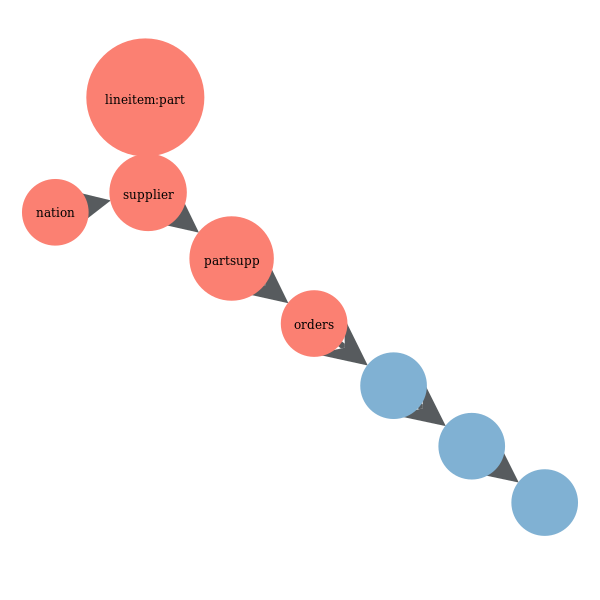

TPCH_Q4


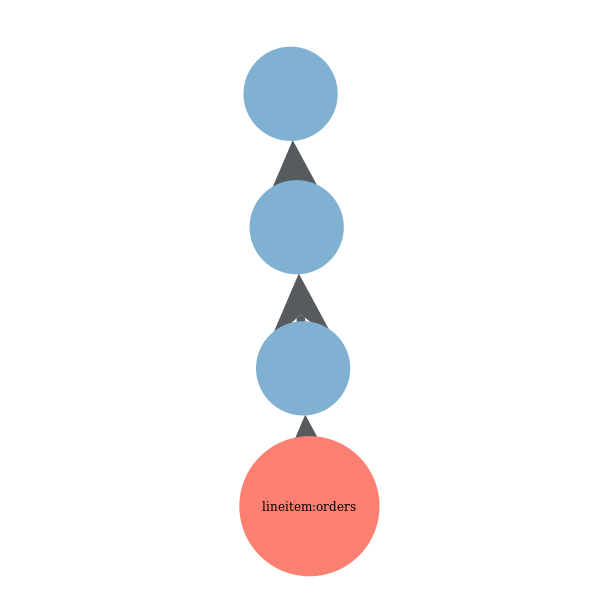

TPCH_Q16


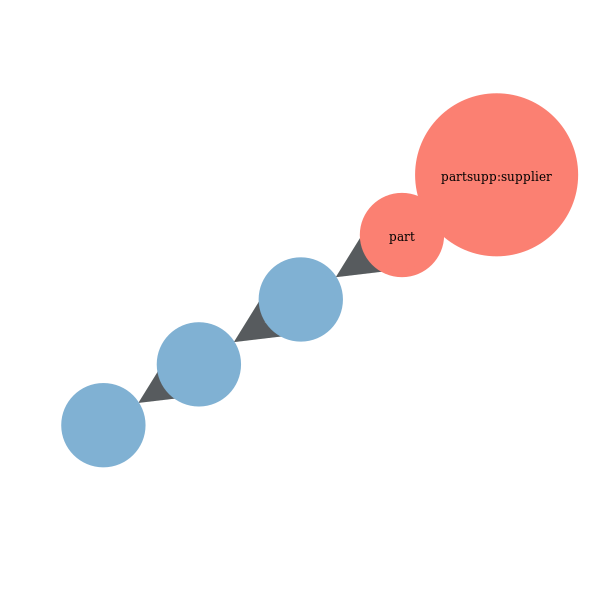

TPCH_Q8


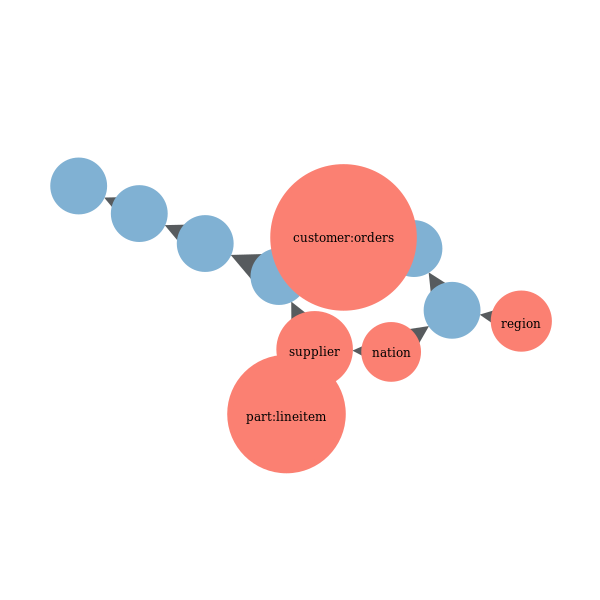

TPCH_Q7


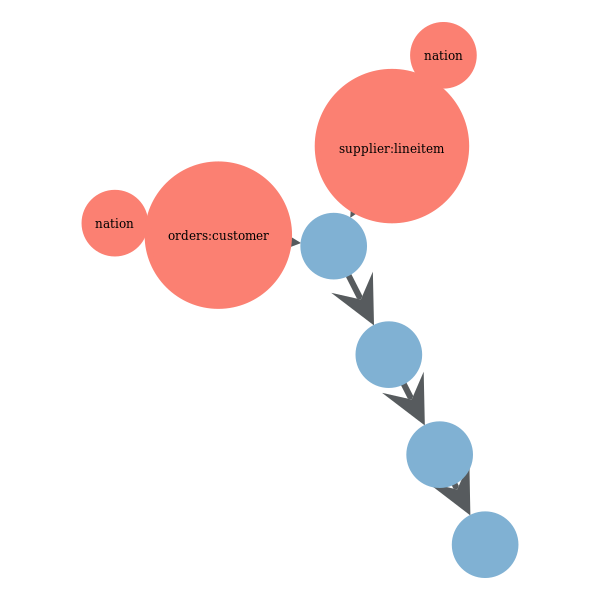

TPCH_Q22


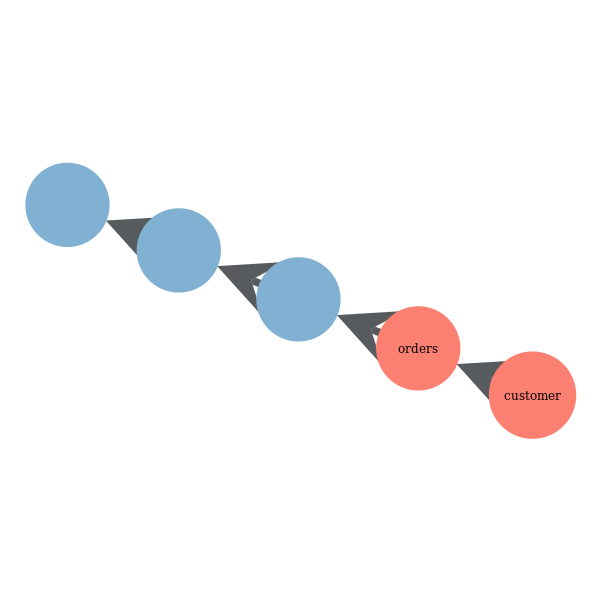

TPCH_Q19


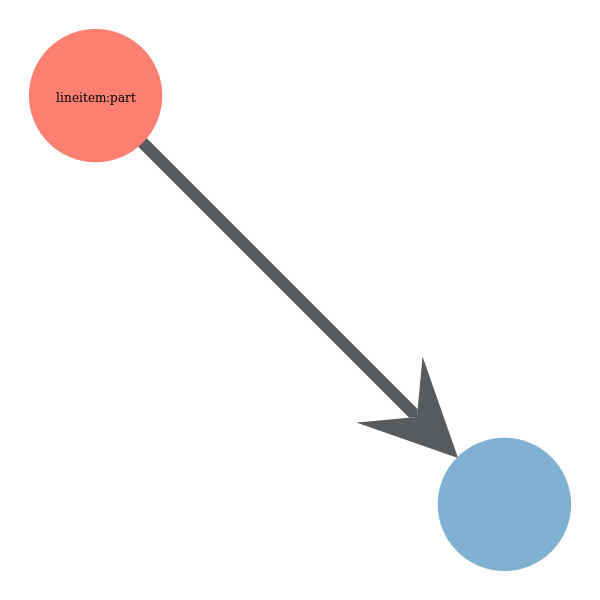

TPCH_Q6


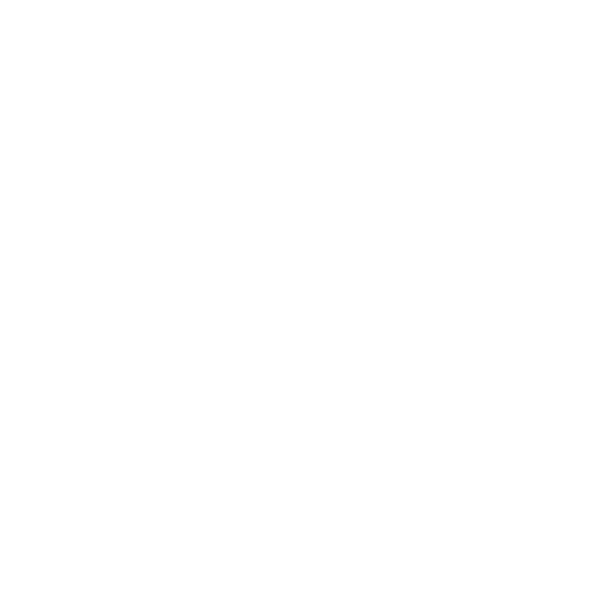

TPCH_Q3


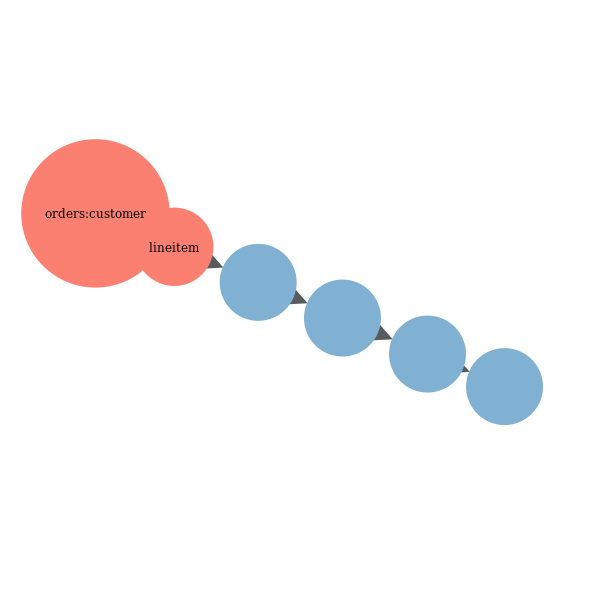

TPCH_Q5


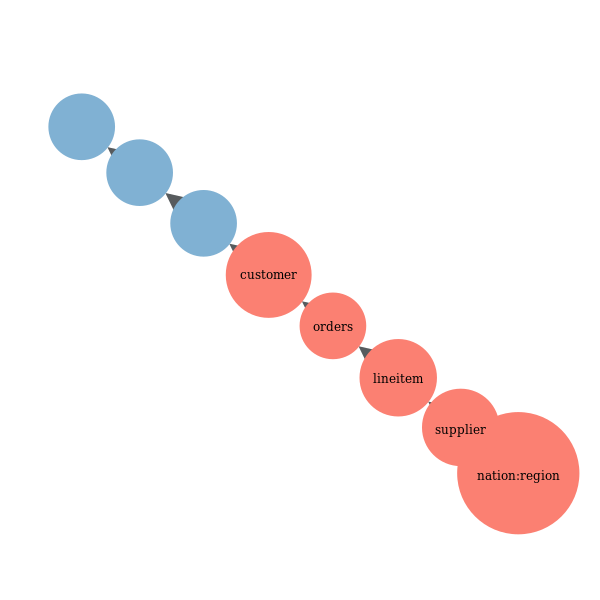

TPCH_Q15


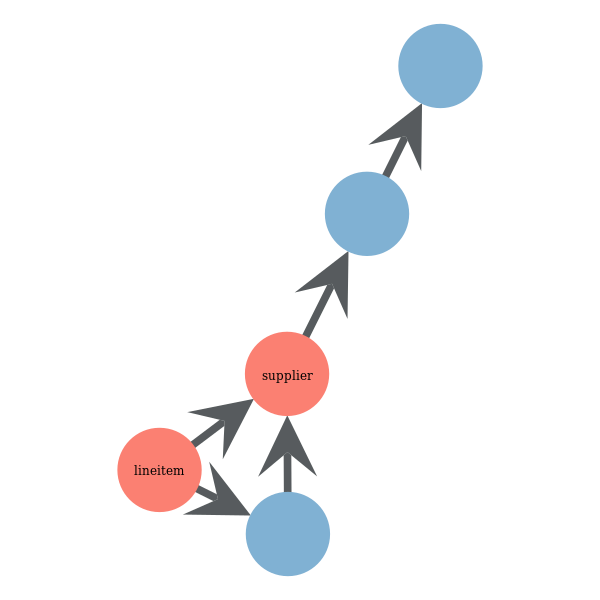

TPCH_Q18


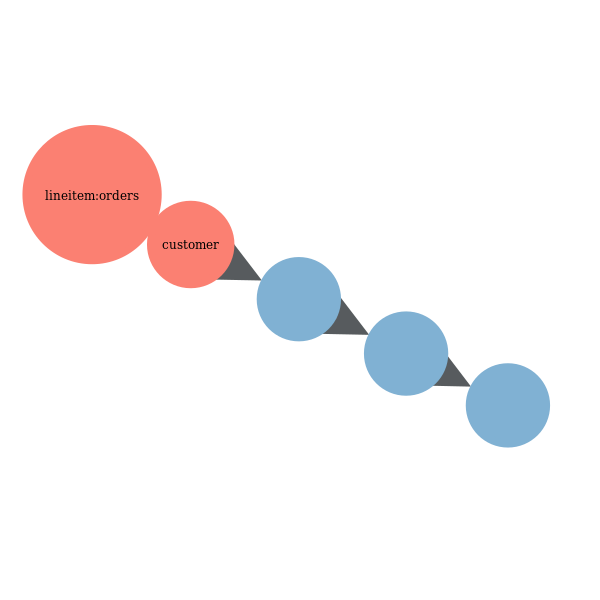

TPCH_Q13


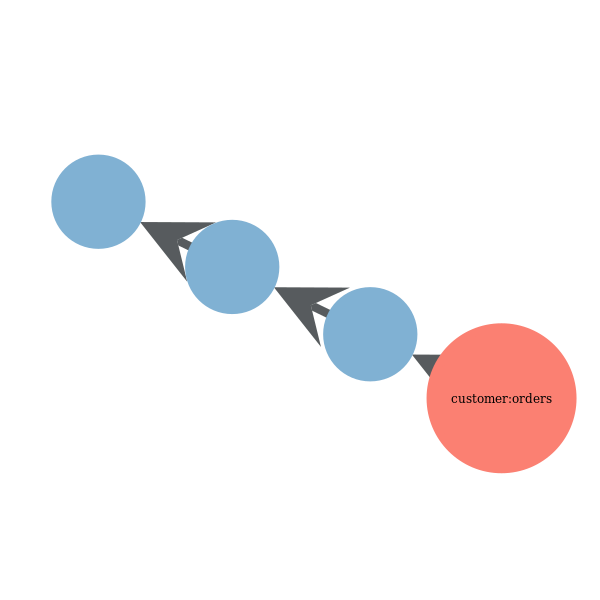

TPCH_Q10


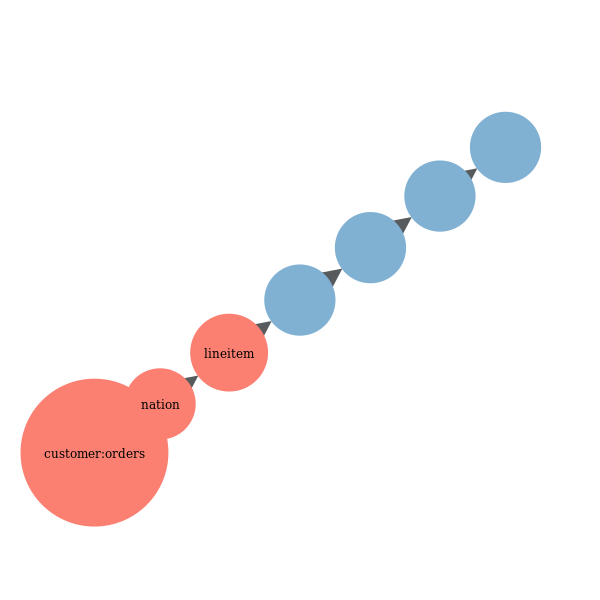

TPCH_Q14


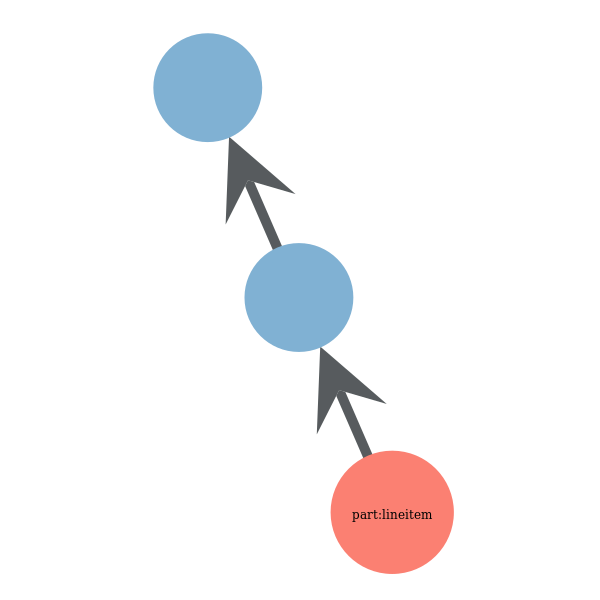

TPCH_Q20


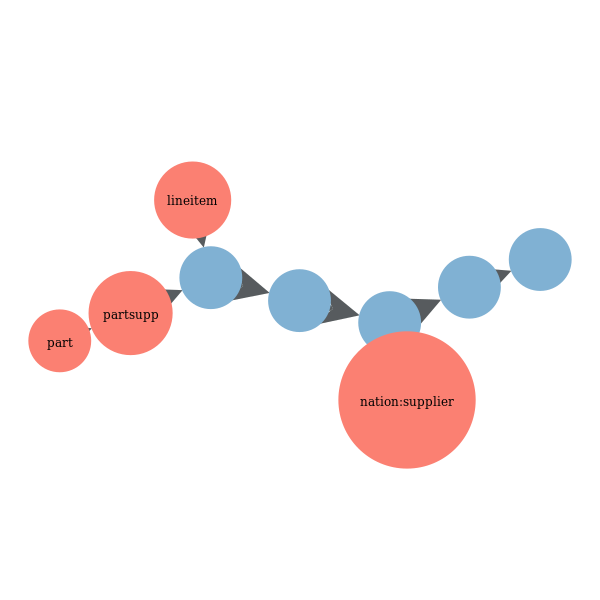

TPCH_Q21


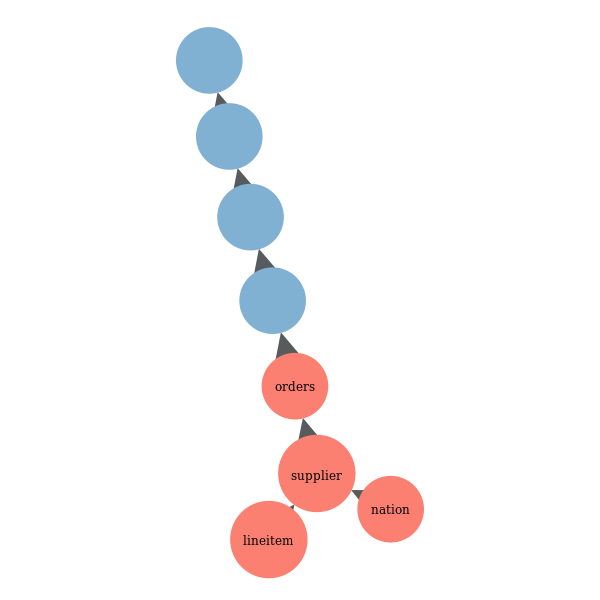

TPCH_Q2


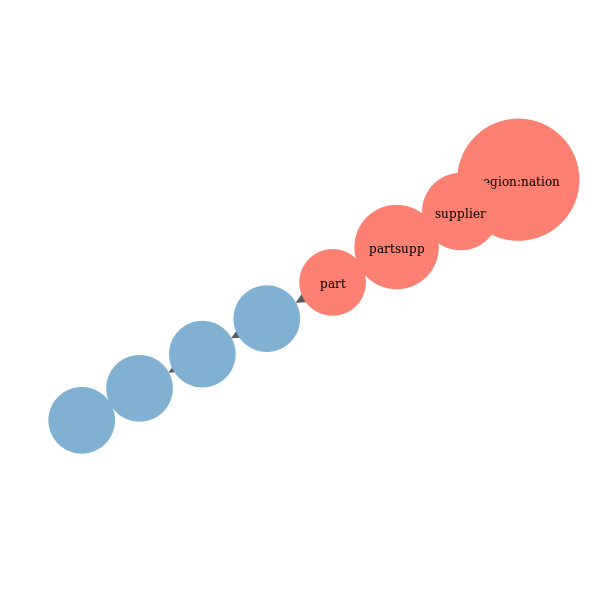

TPCH_Q11


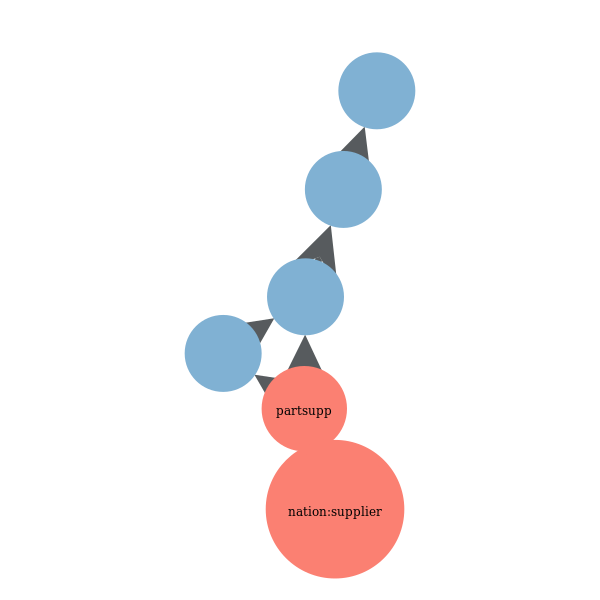

TPCH_Q1


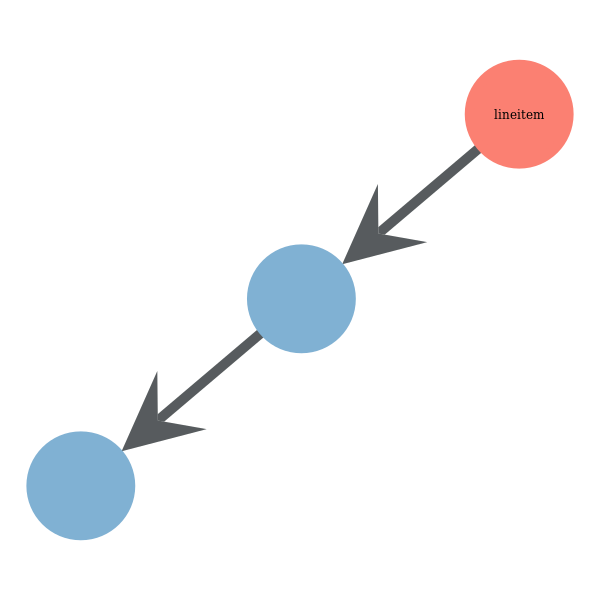

In [194]:
# read graphs and build graph pool 
import graph_tool.all as gt

def build_input_format(inputs_str):
    return ' '.join(inputs_str.split(':')).split()

def load_graph_templates(path):
    graph_skeletons = {}
    with open(path, 'r') as fd:
        graph_strs = fd.read().split('#')[1:]
        for g_str in graph_strs:
            g= build_graph_skeleton(g_str)
            graph_skeletons[g.gp.name] = g
    return graph_skeletons


def build_graph_skeleton(g_str):
    g_elements = g_str.split('\n')
    g_name = g_elements[0].split('\t')[1]
    g_id = 0
    g_queuetime = 0

    g = gt.Graph(directed=True)
    g.gp['name'] = g.new_graph_property("string", g_name)
    g.gp['id'] = g.new_graph_property("string", str(g_id))
    g.gp['queue_time'] = g.new_graph_property("int", g_queuetime)
    g.gp['cur_stage'] = g.new_graph_property("int", -1)
    status = g.new_vertex_property("int")
    inputs = g.new_vertex_property("string")
    cache_runtime = g.new_vertex_property("int")
    remote_runtime = g.new_vertex_property("int")
    color = g.new_vertex_property("string")
    ops = g.new_vertex_property("string")

    # build vertices
    for el in g_elements[1:]:
        if el.startswith('v'):
            vid, operation, inputs_str = el.split(',')[1:]
            v = g.add_vertex()

            inputs[v] = inputs_str #build_input_format(inputs_str)
            #print(inputs_str)
            color[v] = '#fb8072' if len(inputs[v]) > 0 else '#80b1d3'
            cache_runtime[v] = 0
            remote_runtime[v] = 0
            ops[v] = operation if operation else 'SAVE'

    # build edges
    for el in g_elements[1:]:
        if el.startswith('e'):
            v_src, v_dest = el.split(',')[1:]
            e = g.add_edge(v_src, v_dest)

    g.vp['color'] = color
    g.vp['tables'] = inputs
    g.vp['remote_runtime'] = remote_runtime
    g.vp['cache_runtime'] = cache_runtime
    g.vp['status'] = status
    g.vp['feature'] = ops
    
    print(g_name)
    gt.graph_draw(g, vertex_text=g.vp.tables, vertex_color=g.vp.color, 
                  vertex_fill_color=g.vp.color, size=(300, 300))
    return g

graphs_pool = load_graph_templates('/local0/Kariz/expriments/simulator/multidag/%s'%('pig.tpch.template'))

In [174]:
print(graphs_pool.keys())

dict_keys(['TPCH_Q12', 'TPCH_Q17', 'TPCH_Q9', 'TPCH_Q4', 'TPCH_Q16', 'TPCH_Q8', 'TPCH_Q7', 'TPCH_Q22', 'TPCH_Q19', 'TPCH_Q6', 'TPCH_Q3', 'TPCH_Q5', 'TPCH_Q15', 'TPCH_Q18', 'TPCH_Q13', 'TPCH_Q10', 'TPCH_Q14', 'TPCH_Q20', 'TPCH_Q21', 'TPCH_Q2', 'TPCH_Q11', 'TPCH_Q1'])


In [199]:
dt['query_runtime'].fillna(-1, inplace=True)
#result2[(result2['app_name'] == index) & (result2['path'].isin(inputs))]['prefetched'].astype(int).sum()

gpq = dt[dt['query_runtime'] > 0].groupby(by='app_name')


print(dt.groupby(by='app_name').ngroups, gpq.ngroups)

for index, dg in gpq:
    app_meta = dict([i.split(':') for i in index.replace('framework:pig:', '').split('-')])
    query = 'TPCH_Q%s'%(app_meta['name'].replace('tpch', ''))
    print(app_meta, query)
    
    dx = pd.DataFrame()
    dx['feature'] = dg['Feature']
    dx['input_sz'] = dg['total_bytes']
    dx['cache_read'] =  dg['prefetched_blocks']/bw_cache
    dx['remote_read'] = np.abs((dg['total_remote_bytes'] - dg['prefetched_blocks'])/(dg['bw_i']*8*(10**9)))
    #df2['remote_read'] = df2['remote_read'].apply(lambda rread: 0 if rread < 0 else rread)
    dx['sequential'] = dg['total_bytes'] + dg['total_remote_bytes']
    dx['aggregate'] = np.log(dg['Maps'] + dg['Reduces'])
    dx['shuffle'] = (dg['Maps'] + dg['Reduces'])#*dt['total_bytes']
    dx['runtime'] = dg['runtime']
    dx['tables'] = dg['tables']

    g = graphs_pool[query].copy()
    actual_runtime = g.new_vertex_property('float')
    pred_runtime = g.new_vertex_property('float')
    
    for v in g.vertices():
        X = dx[(dx['feature'] == g.vp.feature[v].replace(':', ',')) & (dx['tables'] == g.vp.tables[v])][['remote_read',
                                                                'cache_read', 'sequential', 'shuffle', 'aggregate']].values
        #print(g.vp.tables[v])
        if g.vp.feature[v].replace(':', ',') in regressors:
            regressor = regressors[g.vp.feature[v].replace(':', ',')]
            y_pred = regressor.predict(X)
            actual_runtime[v] = round(dx[(dx['feature'] == g.vp.feature[v].replace(':', ',')) & (dx['tables'] == g.vp.tables[v])]['runtime'].values[0], 2)
        else:
            y_pred = [10]
            
        pred_runtime[v] = round(y_pred[0], 2) 
        print(g.vp.feature[v].replace(':', ','), v, pred_runtime[v], actual_runtime[v])
    print('*********************************')
    #break

dx
    


338 131
{'name': 'tpch1', 'bw': '10Gbps', 'ds': '32G', 'stride': '100'} TPCH_Q1
GROUP_BY,COMBINER 0 1591.4 97.63
SAMPLER 1 10.58 10.68
ORDER_BY 2 10.64 11.13
*********************************
{'name': 'tpch1', 'bw': '1Gbps', 'ds': '20G', 'stride': '70'} TPCH_Q1
GROUP_BY,COMBINER 0 1021.67 67.93
SAMPLER 1 10.58 10.69
ORDER_BY 2 10.64 11.69
*********************************
{'name': 'tpch1', 'bw': '1Gbps', 'ds': '32G', 'stride': '0'} TPCH_Q1
GROUP_BY,COMBINER 0 1696.48 228.31
SAMPLER 1 10.58 10.83
ORDER_BY 2 10.64 10.97
*********************************
{'name': 'tpch1', 'bw': '20Gbps', 'ds': '20G', 'stride': '90'} TPCH_Q1
GROUP_BY,COMBINER 0 999.49 73.01
SAMPLER 1 10.58 11.02
ORDER_BY 2 10.64 9.64
*********************************
{'name': 'tpch1', 'bw': '20Gbps', 'ds': '64G', 'stride': '10'} TPCH_Q1
GROUP_BY,COMBINER 0 3088.33 149.51
SAMPLER 1 10.58 9.74
ORDER_BY 2 10.64 10.87
*********************************
{'name': 'tpch10', 'bw': '1Gbps', 'ds': '20G', 'stride': '40'} TPCH_Q10
HASH

HASH_JOIN 0 142.71 57.64
HASH_JOIN 1 89.08 91.4
GROUP_BY,COMBINER 2 21.97 29.32
SAMPLER 3 10.59 10.95
ORDER_BY 4 11.35 10.66
*********************************
{'name': 'tpch16', 'bw': '10Gbps', 'ds': '32G', 'stride': '60'} TPCH_Q16
HASH_JOIN 0 195.13 90.47
HASH_JOIN 1 114.35 171.04
GROUP_BY,COMBINER 2 27.6 47.95
SAMPLER 3 10.59 11.34
ORDER_BY 4 11.36 11.82
*********************************
{'name': 'tpch16', 'bw': '1Gbps', 'ds': '20G', 'stride': '10'} TPCH_Q16
HASH_JOIN 0 140.37 72.6
HASH_JOIN 1 88.85 105.7
GROUP_BY,COMBINER 2 21.97 29.24
SAMPLER 3 10.59 11.6
ORDER_BY 4 11.35 11.13
*********************************
{'name': 'tpch16', 'bw': '1Gbps', 'ds': '32G', 'stride': '50'} TPCH_Q16
HASH_JOIN 0 198.74 95.59
HASH_JOIN 1 115.05 189.06
GROUP_BY,COMBINER 2 27.6 55.48
SAMPLER 3 10.59 10.68
ORDER_BY 4 11.36 11.86
*********************************
{'name': 'tpch16', 'bw': '20Gbps', 'ds': '20G', 'stride': '90'} TPCH_Q16
HASH_JOIN 0 143.87 56.47
HASH_JOIN 1 89.06 93.82
GROUP_BY,COMBINER 2 21

HASH_JOIN 5 45.98 198.38
HASH_JOIN 6 45.1 15.44
SAMPLER 7 10.58 10.89
ORDER_BY 8 11.03 10.98
*********************************
{'name': 'tpch20', 'bw': '40Gbps', 'ds': '32G', 'stride': '60'} TPCH_Q20
GROUP_BY,COMBINER 0 1573.35 143.92
HASH_JOIN 1 39.63 101.26
DISTINCT 2 1091.5 16.49
HASH_JOIN 3 192.86 51.44
DISTINCT 4 11.55 11.28
HASH_JOIN 5 39.63 101.26
HASH_JOIN 6 41.44 12.17
SAMPLER 7 10.58 10.62
ORDER_BY 8 10.84 10.28
*********************************
{'name': 'tpch20', 'bw': '5Gbps', 'ds': '20G', 'stride': '40'} TPCH_Q20
GROUP_BY,COMBINER 0 995.12 95.34
HASH_JOIN 1 38.73 67.14
DISTINCT 2 684.88 13.39
HASH_JOIN 3 138.11 37.27
DISTINCT 4 10.58 11.27
HASH_JOIN 5 38.73 67.14
HASH_JOIN 6 37.43 13.15
SAMPLER 7 10.58 9.86
ORDER_BY 8 10.76 10.99
*********************************
{'name': 'tpch21', 'bw': '10Gbps', 'ds': '32G', 'stride': '20'} TPCH_Q21
GROUP_BY,MULTI_QUERY 0 21730870.74 1017.08
REPLICATED_JOIN,HASH_JOIN 1 81.71 76.14
MAP_ONLY 2 5.82 5.82
HASH_JOIN 3 198.35 67.73
GROUP_BY,CO

SAMPLER 6 10.58 11.22
ORDER_BY 7 10.64 9.96
*********************************
{'name': 'tpch7', 'bw': '1Gbps', 'ds': '32G', 'stride': '60'} TPCH_Q7
MAP_ONLY 0 5.82 5.38
REPLICATED_JOIN,HASH_JOIN 1 360.72 268.29
HASH_JOIN 2 39.04 52.59
MAP_ONLY 3 5.82 5.38
REPLICATED_JOIN,HASH_JOIN 4 207.3 172.35
GROUP_BY,COMBINER 5 13.19 11.63
SAMPLER 6 10.58 11.59
ORDER_BY 7 10.64 10.87
*********************************
{'name': 'tpch7', 'bw': '20Gbps', 'ds': '20G', 'stride': '50'} TPCH_Q7
MAP_ONLY 0 5.82 5.95
REPLICATED_JOIN,HASH_JOIN 1 171.79 118.62
HASH_JOIN 2 38.36 35.17
MAP_ONLY 3 5.82 5.95
REPLICATED_JOIN,HASH_JOIN 4 129.42 71.91
GROUP_BY,COMBINER 5 13.03 10.92
SAMPLER 6 10.58 10.83
ORDER_BY 7 10.64 9.65
*********************************
{'name': 'tpch7', 'bw': '5Gbps', 'ds': '20G', 'stride': '100'} TPCH_Q7
MAP_ONLY 0 5.82 5.64
REPLICATED_JOIN,HASH_JOIN 1 171.97 115.25
HASH_JOIN 2 38.36 36.89
MAP_ONLY 3 5.82 5.64
REPLICATED_JOIN,HASH_JOIN 4 129.92 68.34
GROUP_BY,COMBINER 5 13.03 11.14
SAMPLER 6 

,feature,input_sz,cache_read,remote_read,sequential,aggregate,shuffle,runtime,tables
468,MAP_ONLY,368,0.000000,5.497500e-08,2567,0.000000,1,6.251,nation
469,HASH_JOIN,23542,2.556848,8.166023e-02,16050671294,4.110874,61,214.656,lineitem:part
470,"REPLICATED_JOIN,HASH_JOIN",320382267,0.000000,7.067878e-04,348653779,1.098612,3,67.908,supplier
471,HASH_JOIN,391115973,0.385037,1.204325e-02,2798031359,3.737670,42,123.943,partsupp
472,HASH_JOIN,386525750,0.557842,1.745691e-02,3874014116,3.737670,42,169.490,orders
473,"GROUP_BY,COMBINER",211074483,0.000000,0.000000e+00,211074483,0.693147,2,41.726,
474,SAMPLER,5656,0.000000,0.000000e+00,5656,0.693147,2,9.900,
475,ORDER_BY,5656,0.000000,0.000000e+00,5656,0.693147,2,11.077,


In [ ]:
result2.head(5)

In [208]:
dt['input_size']= dt['total_remote_bytes'] + dt['total_bytes']
dfsh = dt[dt['Feature']=='HASH_JOIN'][['prefetched_blocks', 'total_remote_bytes', 'total_bytes', 'input_size' , 'runtime']].sort_values(by='input_size')

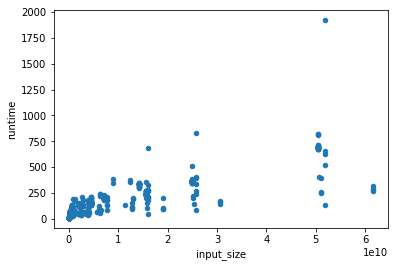

In [209]:
dfsh.plot.scatter(x='input_size', y = 'runtime')